In [1]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW, Nadam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.mixed_precision import set_global_policy

In [2]:
print("Tf version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
print("CUDA version:", os.environ.get("CUDA_VERSION"))
print("cuDNN version:", os.environ.get("CUDNN_VERSION"))

Tf version: 2.16.1
GPUs: []
CUDA version: None
cuDNN version: None


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
df = pd.read_csv('../../data/pre_train/aapl.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.astype(float)

In [5]:
y = df['log_close']
X = df.drop('log_close', axis=1)

In [6]:
time_steps = 67
def create_sequences(X, y, time_steps=time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i + time_steps].values)
        y_seq.append(y.iloc[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [7]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print("MAE train:", mae_train)
    print("MAE test:", mae_test)
    print("RMSE train:", rmse_train)
    print("RMSE test:", rmse_test)
    print("R2 train:", r2_train)
    print("R2 test:", r2_test)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [10]:
X_train_seq, y_train_seq = create_sequences(pd.DataFrame(X_train_scaled), y_train)
X_test_seq, y_test_seq = create_sequences(pd.DataFrame(X_test_scaled), y_test)

In [11]:
apply_pca = True
n_components = 10

if apply_pca:
    pca = PCA(n_components=n_components)
    X_train_seq_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
    X_test_seq_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])
    
    X_train_pca = pca.fit_transform(X_train_seq_flat)
    X_test_pca = pca.transform(X_test_seq_flat)

    X_train_seq = X_train_pca.reshape(-1, time_steps, n_components)
    X_test_seq = X_test_pca.reshape(-1, time_steps, n_components)

In [12]:
scaler_y = MinMaxScaler()
y_train_seq_scaled = scaler_y.fit_transform(y_train_seq.reshape(-1, 1)).flatten()
y_test_seq_scaled = scaler_y.transform(y_test_seq.reshape(-1, 1)).flatten()

In [13]:
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

In [15]:
history = model.fit(X_train_seq, y_train_seq_scaled,
                    epochs=75, batch_size=150, shuffle=False,
                    validation_data=(X_test_seq, y_test_seq_scaled),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - loss: 0.5579 - mae: 0.5365 - val_loss: 0.5957 - val_mae: 0.6824
Epoch 2/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.2511 - mae: 0.3501 - val_loss: 0.1288 - val_mae: 0.1517
Epoch 3/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.4341 - mae: 0.4830 - val_loss: 0.2007 - val_mae: 0.2738
Epoch 4/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.2633 - mae: 0.3762 - val_loss: 0.1115 - val_mae: 0.1303
Epoch 5/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.1679 - mae: 0.2368 - val_loss: 0.1052 - val_mae: 0.1222
Epoch 6/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.1620 - mae: 0.2045 - val_loss: 0.1442 - val_mae: 0.2121
Epoch 7/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.1402 - mae: 0.1906 - val_loss: 0.1031 - val_mae: 0.1330
Epoch 8/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.1186 - mae: 0.1603 - val_loss: 0.0907 - val_mae: 0.0826
Epoch 9/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.1047 - mae: 

In [16]:
y_pred_train_scaled = model.predict(X_train_seq)
y_pred_test_scaled = model.predict(X_test_seq)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [17]:
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_train_true = scaler_y.inverse_transform(y_train_seq_scaled.reshape(-1, 1))
y_test_true = scaler_y.inverse_transform(y_test_seq_scaled.reshape(-1, 1))

In [18]:
evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true)

MAE train: 0.01973925157471753
MAE test: 0.013450476351636622
RMSE train: 0.0251274070802657
RMSE test: 0.017574087280561347
R2 train: 0.9877307804100183
R2 test: 0.9752194727062411


In [19]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predictions vs Real values")
    plt.legend()
    plt.show()

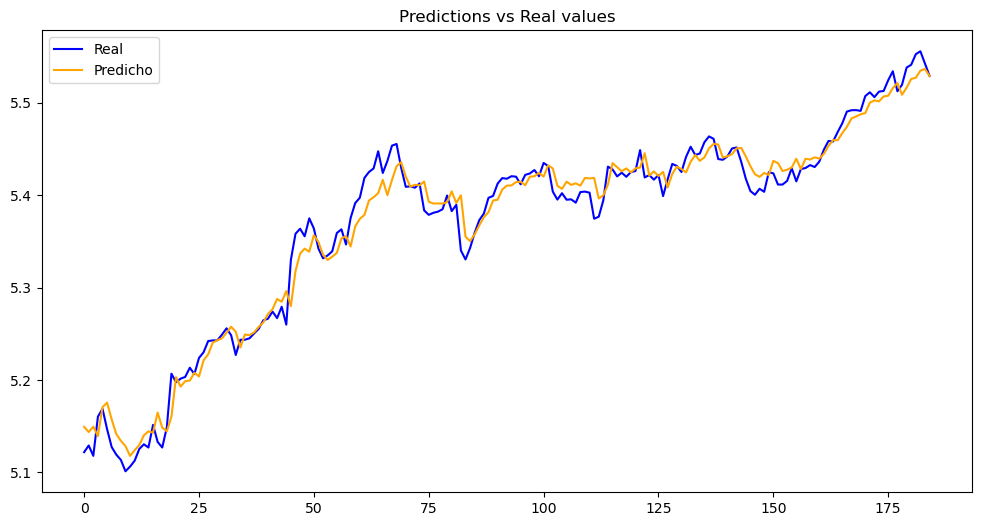

In [20]:
plot_predictions(y_test_true, y_pred_test)

In [21]:
y_test_true.mean()

5.368319451191618

In [22]:
model.save("model_lstm_aapl_close.keras")